<h2>Basic Imports</h2>

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

<h2>Set Image Sources </h2> 

In [4]:
img_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v0/son_of_alignment_v15_rechunked"
seg_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v185/seg"

<h2> Method 1: Using CloudVolume to download images </h2>


In [ ]:
import cloudvolume

<h3>Download and Looking at an Image</h3>

In [27]:
#Initialize cloudvolume connection
img_cv = cloudvolume.CloudVolume(img_source, use_https=True)

In [28]:
#Look at the data bounds
img_cv.bounds

Bbox([35000, 31000, 1],[125000, 84500, 2177], dtype=int32)

In [32]:
#Download
img = img_cv[70000:70000+500, 70000:70000+500, 1025:1026]


Downloading: 100%|██████████| 9/9 [00:20<00:00, 15.48it/s]

In [30]:
#Check size of image
img.shape

(500, 500, 1, 1)


Downloading: 100%|██████████| 9/9 [00:14<00:00, 11.33it/s]

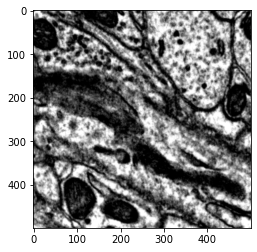

Downloading: 100%|██████████| 9/9 [00:16<00:00,  8.88it/s]

In [8]:
#Look at the image
plt.imshow(np.squeeze(img), cmap=plt.cm.gray)

<h3> Downloading and Looking at a Segmentation </h3>


In [50]:
#Initialize cloudvolume connection
seg_cv = cloudvolume.CloudVolume(seg_source)

In [51]:
#Look at the data bounds
seg_cv.bounds

Bbox([17920, 14848, 0],[61440, 40960, 2176], dtype=int32)

In [52]:
#Download Segmentation
seg = seg_cv[35000:35000+250, 35000:35000+250, 1025]
#Check shape of Image
seg.shape

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

(250, 250, 1, 1)

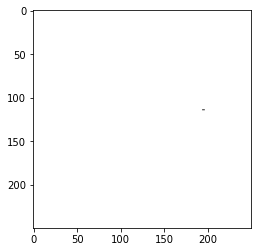

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


In [53]:
#Look at the image
plt.imshow(np.squeeze(seg), cmap=plt.cm.gray)

<h3> Use Remapping </h3>

Now because each pixel contains the ID of the object, 
visualizing this as a normal image doesn't make sense
fastremap can help you map these large IDs to smaller ones
so visualization makes more sense as an image

In [57]:
import fastremap
# may be much faster than np.unique
uniq, cts = fastremap.unique(seg, return_counts=True)
#list of ids in this cutout
uniq


array([                 0, 648518346349493031, 648518346349489855,
       648518346349539900, 648518346349539590, 648518346342162893,
       648518346341397520, 648518346342167007, 648518346341390506,
       648518346341363379, 648518346341369428, 648518346342161920,
       648518346342099875, 648518346349537989, 648518346342159814,
       648518346349508722, 648518346341393364, 648518346342161983,
       648518346349538001], dtype=uint64)

<h3>Look at remapping</h3>

In [58]:
# relabel values from 1 and refit data type
remappedseg, remapping = fastremap.renumber(seg, in_place=True)

remapping

{648518346341393364: 16,
 648518346342159814: 14,
 648518346349537989: 13,
 648518346342099875: 12,
 648518346342161920: 11,
 648518346341369428: 10,
 648518346341363379: 9,
 648518346341397520: 6,
 648518346349493031: 1,
 0: 0,
 648518346349539590: 4,
 648518346341390506: 8,
 648518346349538001: 18,
 648518346349508722: 15,
 648518346342167007: 7,
 648518346342162893: 5,
 648518346342161983: 17,
 648518346349539900: 3,
 648518346349489855: 2}

<h3>Visualize</h3>

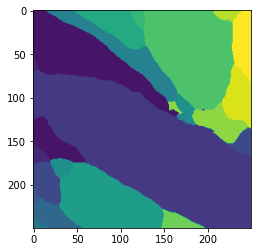

In [59]:
plt.imshow(np.squeeze(remappedseg))

NOTE: the segmentation full resolution is at half the resolution
of the imagery so there isn't a 1-1 correspondance between pixels

In [60]:
seg.shape, img.shape

((250, 250, 1, 1), (500, 500, 1, 1))

<h2>Method 2: Using the Imagery Client </h2>

The ImageryClient can help you think less
about how to manage bounds between segmentation and images layers
when you are trying to make cutouts

In [62]:
from imageryclient import ImageryClient

<h3> Initialize Imagery client with image and segmentation source </h3>

In [17]:
ic=ImageryClient(image_source = img_source,
                 segmentation_source=seg_source)

<h3> Lets visualize the image and segmentation in the area
that surrounds a random synapse </h3>

In [64]:
syn_df = pd.read_csv('../data/soma_subgraph_synapses_spines_v185.csv')
syn_num = 400
post_id =syn_df.loc[syn_num,'post_root_id']
pre_id = syn_df.loc[syn_num,'pre_root_id']
syn=syn_df.loc[syn_num]

<h3> Pick 5 consecutive sections centered around this synapse</h3>

This will pick out bounds with a 300 pixel (3.58*300 = 1027 nm) x,y region
and 5 sections @40 nm in z. Note that because of how slices work, for example, a lower bound of z and an upper bound of z+3 only returns the sections at z, z+1, and z+2 but is not inclusive of z+3.

In [65]:
bounds=[[syn.ctr_pos_x_vx-150, syn.ctr_pos_y_vx-150, syn.ctr_pos_z_vx-2],
        [syn.ctr_pos_x_vx+150, syn.ctr_pos_y_vx+150, syn.ctr_pos_z_vx+3]]

<h3>Download the cutouts</h3>

In [66]:
imgvol, segdict = ic.image_and_segmentation_cutout(bounds,
                                                   split_segmentations=True)

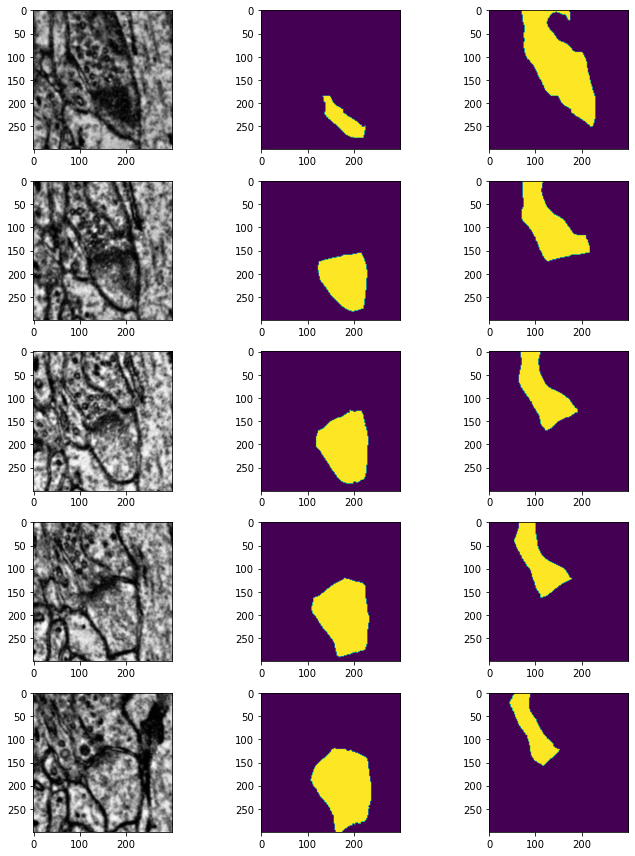

In [67]:
f ,ax = plt.subplots(5,3, figsize=(10,12))
# lets loop over z sections
for i in range(5):
    # plot the images in column 0
    ax[i, 0].imshow(np.squeeze(imgvol[:,:,i]),
                    cmap=plt.cm.gray,
                    vmax=255,
                    vmin=0)
    # plot the pre-synaptic mask in column 1
    ax[i, 1].imshow(np.squeeze(segdict[post_id][:,:,i]))
    # plot the post-synaptic mask in column 2
    ax[i, 2].imshow(np.squeeze(segdict[pre_id][:,:,i]))
f.tight_layout()

<h3>Save Images</h3>

This function will save a series of PNG images that are exactly the same size
so you can easily combine them as layers in Illustrator or photoshop
to make a publication quality figures

In [22]:
ic.save_image_and_segmentation_masks('synapse_test', bounds=bounds,
                                     root_ids = [pre_id, post_id],
                                     segmentation_colormap={pre_id:[255, 0,0,255], 
                                                            post_id:[0, 255, 0 ,255]})